# Spectral Proper Orthogonal Decomposition of a free jet

#### load moduls

In [1]:
import numpy as np
from spyod.spod import spod
from spyod.findpairs import findpairs
import scipy.io as sio
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'Verdana'
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

#### load and prepare data

Text(0, 0.5, '$y$ in mm')

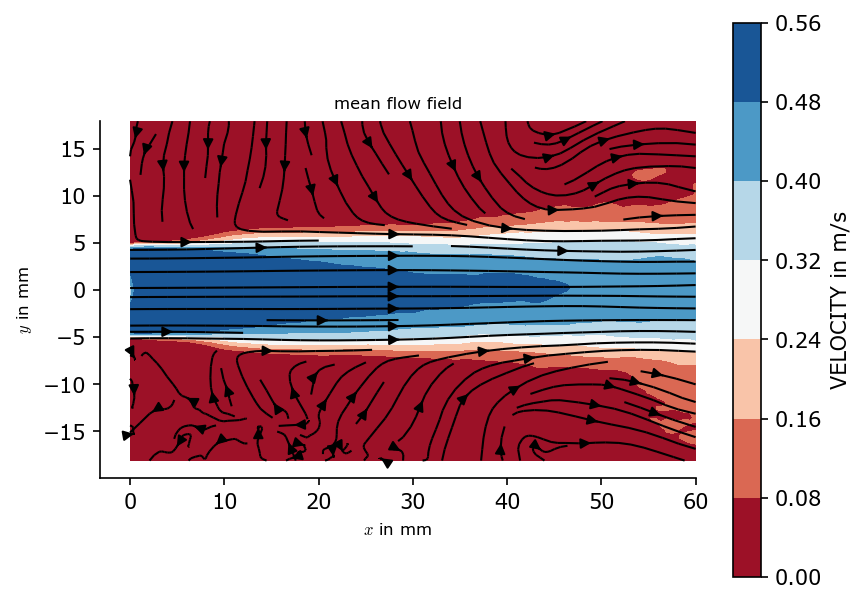

In [3]:
F_AQ = 1 # sample rate

JET_EXAMPLE_DATA = sio.loadmat("PIV_jext_example.mat")

sorted(JET_EXAMPLE_DATA.keys())
U = JET_EXAMPLE_DATA["U"]
V = JET_EXAMPLE_DATA["V"]
X = JET_EXAMPLE_DATA["X"]
Y = JET_EXAMPLE_DATA["Y"]

# reshape matlab to python

U = np.swapaxes(np.swapaxes(U, 0, 2), 1, 2)
V = np.swapaxes(np.swapaxes(V, 0, 2), 1, 2)

U_mean = U.mean(axis=0)
V_mean = V.mean(axis=0)

U_in = U - U_mean[:None]
V_in = V - V_mean[:None]

fig, axs = plt.subplots(dpi=150)

contourfplot = plt.contourf(X,Y,np.sqrt(U_mean**2 + V_mean**2), cmap = 'RdBu')

cbar = plt.colorbar(contourfplot, label="VELOCITY in m/s")

axs.streamplot(X, Y, U_mean, V_mean, density=[1, 1], color = 'k', linewidth = 1, arrowstyle = '-|>')

axs.set_aspect('equal', 'box')
axs.set_title('mean flow field', fontsize = 8)
axs.set_xlabel('$x$ in mm', fontsize = 8)
axs.set_ylabel('$y$ in mm', fontsize = 8)

#### calculate SPOD and find SPOD mode pairs

In [4]:
NF = 25 
CORRELATION_TYPE = 'temporal'
BOUNDARY = "zeros"

lmbd, a, mode_norm, Ui = spod(U_in, V_in, Nfilt = NF,
                                  boundary = BOUNDARY, corr_type = CORRELATION_TYPE)

# truncated according to the energy content 
ENERGY_CONTENT = 0.95

idx = np.argmin(np.abs(np.cumsum(lmbd)/np.sum(lmbd)-ENERGY_CONTENT)) 

# find mode pairs

mode = findpairs(a[:,:idx+1])


Input parameter checked! :) :)
There are 2 components.
Elapsed: 0.00 min


#### plot SPOD spectrum

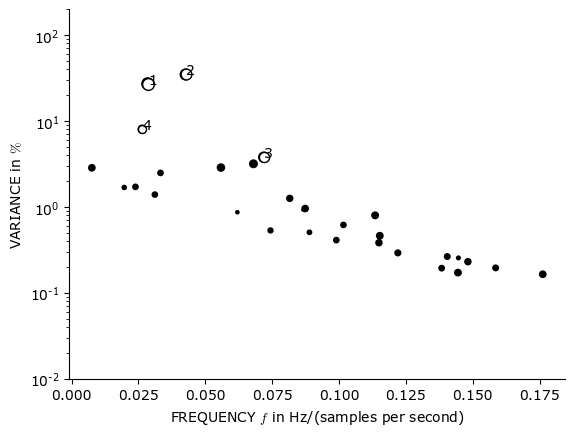

In [5]:
# plot SPOD spectrum

fig, ax = plt.subplots(dpi = 100)

ax.scatter(mode['f']*F_AQ,mode['K']*100,s=mode['c']*50+0.01,c = 'black')
ax.set_yscale('log')

ax.set_ylim((10**-2, 2*10**2))
ax.set_xlabel('FREQUENCY $f$ in Hz/(samples per second)')
ax.set_ylabel('VARIANCE in $\%$')

# mark the first four dominant modes
for i in range(4):
    ax.scatter(mode['f'][i]*F_AQ,mode['K'][i]*100,s=mode['c'][i]*50+0.01,c = 'white',edgecolors='black')
    ax.text(mode['f'][i]*F_AQ,mode['K'][i]*100, str(i+1))



#### plot spatial modes and temporal coefficients

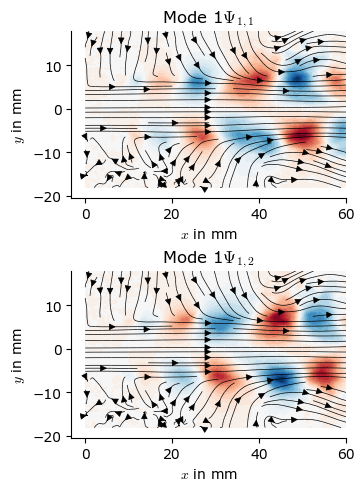

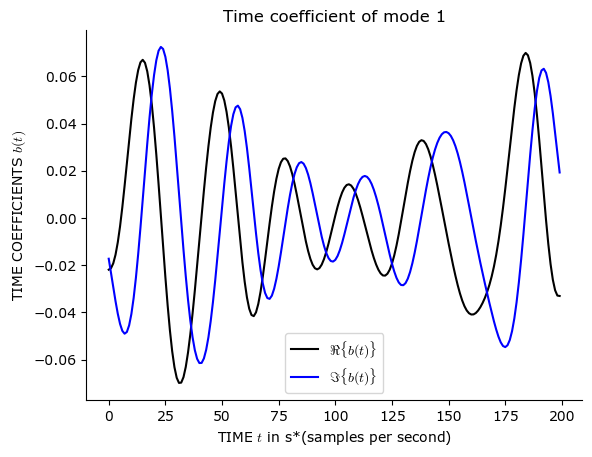

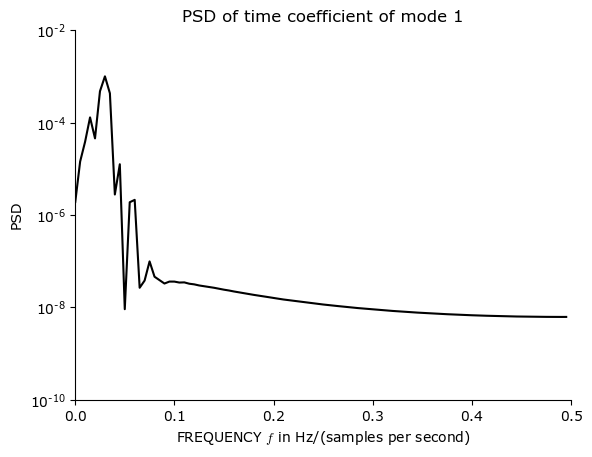

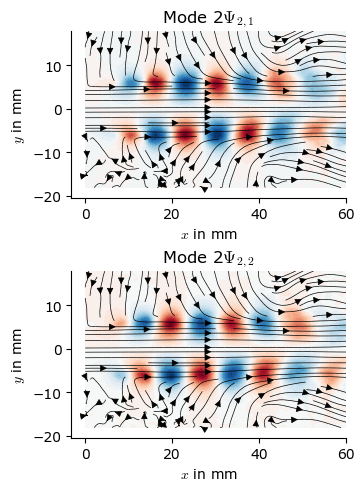

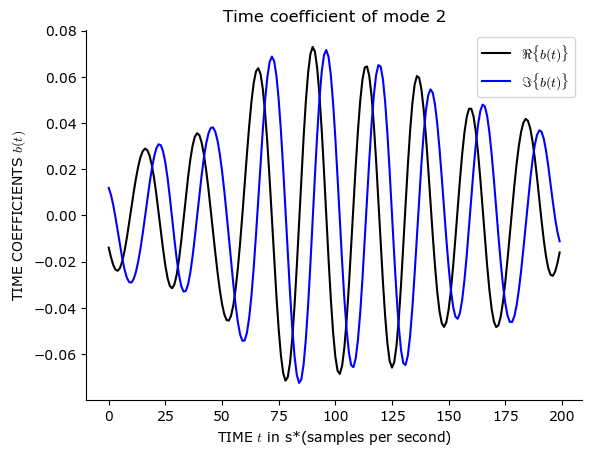

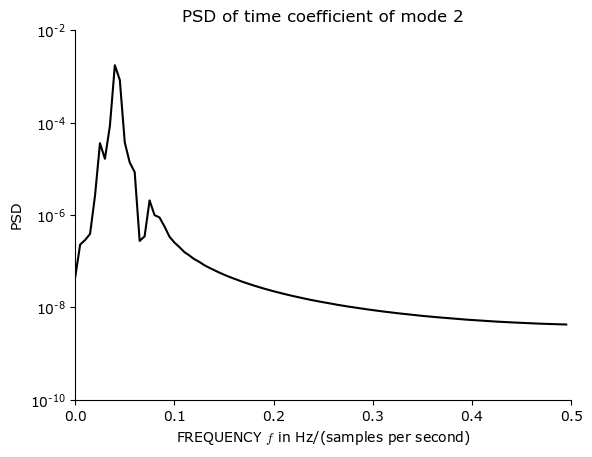

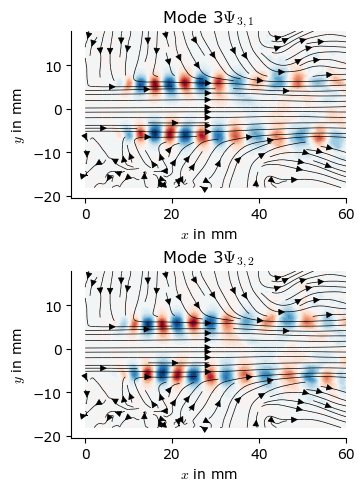

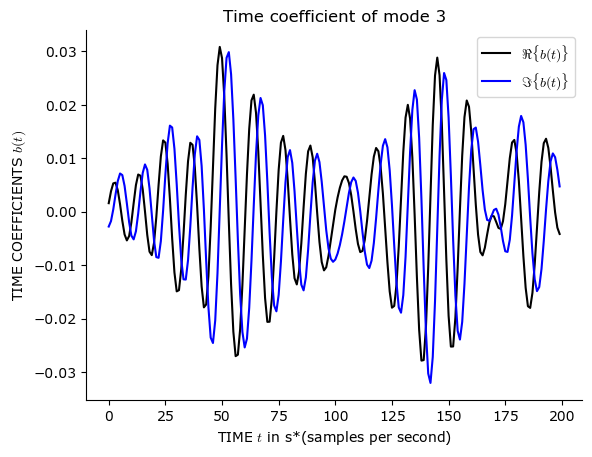

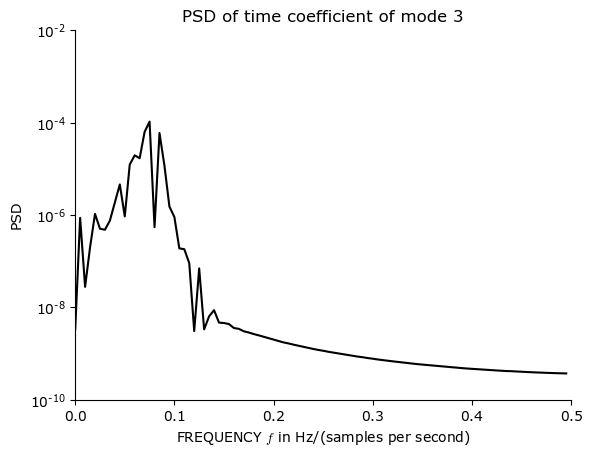

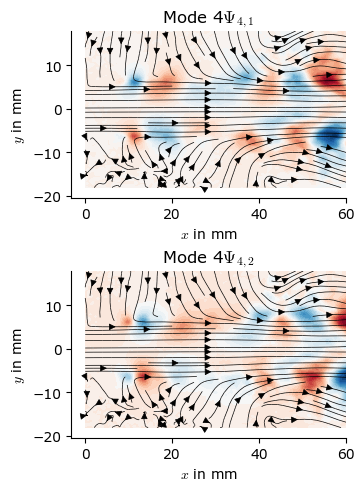

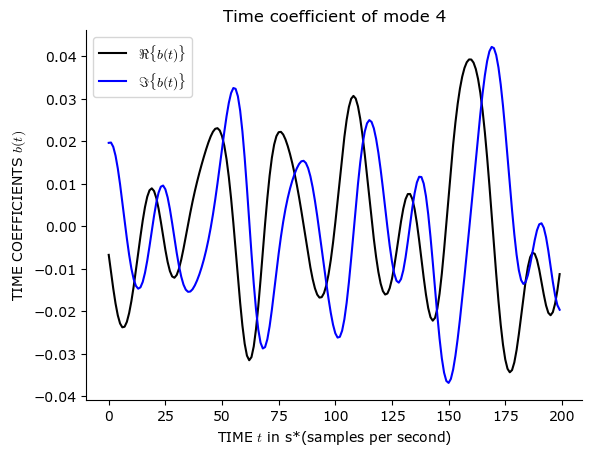

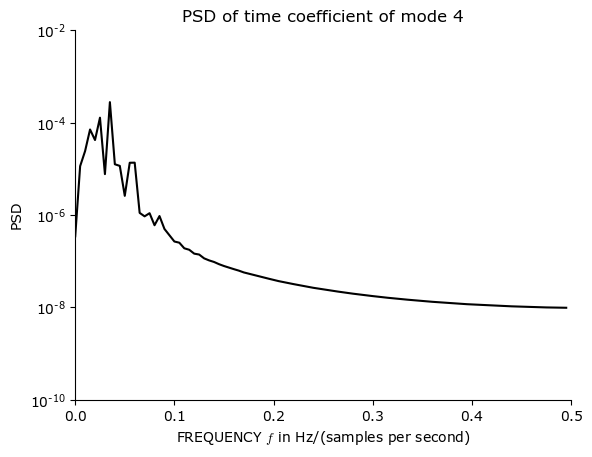

In [6]:
for i in range(4):
    fig, axs = plt.subplots(2, dpi = 100, constrained_layout=True)
    
    axs[0].set_title('Mode ' +str(i+1) + '$ \Psi_{%d,1}$' %(i+1))
    axs[0].contourf(X, Y, Ui[1][int(mode['ind'][i][0])], 40, cmap = 'RdBu')
    axs[0].streamplot(X, Y, U_mean, V_mean, density=[1, 1], color = 'k', linewidth = .5, arrowstyle = '-|>')

    axs[1].set_title('Mode ' +str(i+1) + '$ \Psi_{%d,2}$' %(i+1))
    axs[1].contourf(X, Y, Ui[1][int(mode['ind'][i][1])], 40, cmap = 'RdBu')
    axs[1].streamplot(X, Y, U_mean, V_mean, density=[1, 1], color = 'k', linewidth = .5, arrowstyle = '-|>')

    axs[0].set_aspect('equal', 'box')
    axs[1].set_aspect('equal', 'box')
   
    for axs in axs.flat:
        axs.set(xlabel='$x$ in mm', ylabel='$y$ in mm')
    
    fig, ax = plt.subplots(dpi = 100)

    ax.set_title('Time coefficient of mode ' +str(i+1))

    ax.plot(np.arange(len(mode['a'][i]))/F_AQ,np.real(mode['a'][i]),'k-', label='$\Re\{b(t)\}$')
    ax.plot(np.arange(len(mode['a'][i]))/F_AQ,np.imag(mode['a'][i]),'b-', label='$\Im\{b(t)\}$')
    ax.legend()

    ax.set_xlabel('TIME $t$ in s*(samples per second)')
    ax.set_ylabel('TIME COEFFICIENTS $b(t)$')

    # FFT of temporal coefficient to calculate the PSD
    
    fig, ax = plt.subplots(dpi = 100)

    # absolute value of complex temporal coefficient
    A = np.fft.fftshift(np.abs(np.fft.fft(mode['a'][i], norm = 'forward')))

    FREQS = np.fft.fftfreq(np.abs(mode['a'][i]).size, d = 1/F_AQ)
    FREQS = np.fft.fftshift(FREQS)

    # plot PSD
    ax.plot(FREQS, abs(A)**2,'k')


    ax.set_yscale('log')
    ax.set_xlim((0, .5))
    ax.set_ylim((10**-10, 10**-2))
    ax.set_title('PSD of time coefficient of mode ' +str(i+1))
    ax.set_xlabel('FREQUENCY $f$ in Hz/(samples per second)')
    ax.set_ylabel('PSD')



#### Recomposition of flow field 

Recomposition works!


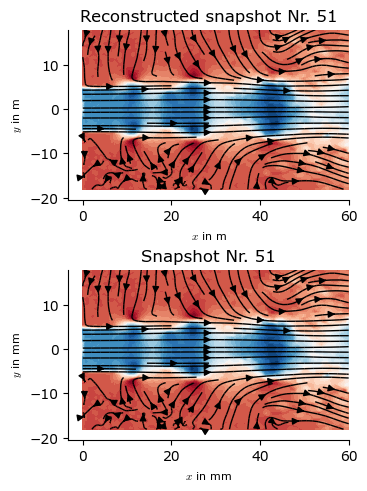

In [34]:
# Which mode should be recomposed?

FRAME_REC = 50

U_rec = np.zeros(Ui[0][0].shape, dtype = np.float32)

for i in range(Ui[0].shape[0]):
   U_rec = U_rec + np.multiply(a[FRAME_REC,i],Ui[0][i,:,:])

# add mean flow field

U_rec = U_mean + U_rec

fig, axs = plt.subplots(2, dpi = 100, constrained_layout=True)
axs[0].set_title('Reconstructed snapshot Nr. %d' %(FRAME_REC+1))
axs[0].contourf(X, Y, U_rec, 40, cmap = 'RdBu')
axs[0].streamplot(X, Y, U_mean, V_mean, density=[1, 1], color = 'k', linewidth = 1, arrowstyle = '-|>')

axs[0].set_aspect('equal', 'box')
axs[0].set_xlabel('$x$ in m', fontsize = 8)
axs[0].set_ylabel('$y$ in m', fontsize = 8)

axs[1].set_title('Snapshot Nr. %d' %(FRAME_REC+1))
axs[1].contourf(X, Y, U[FRAME_REC], 40, cmap = 'RdBu')
axs[1].streamplot(X, Y, U_mean, V_mean, density=[1, 1], color = 'k', linewidth = 1, arrowstyle = '-|>')

axs[1].set_aspect('equal', 'box')
axs[1].set_xlabel('$x$ in mm', fontsize = 8)
axs[1].set_ylabel('$y$ in mm', fontsize = 8)

if (np.round(np.float32(U[FRAME_REC]),5) == np.round(np.float32(U_rec),5)).all():
   print('Recomposition works!')

else:
   print('Recomposition fails!')